# Gaze Perception Analysis Script

In [1]:
import os
import copy
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import *
from grace.utils import *
import pandas as pd
import dlib
from sklearn.linear_model import LinearRegression
import seaborn as sns 

## Helper Functions

In [2]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")
camera_mtx_params = load_camera_mtx()
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_pickle_files(folder_path):
    pickle_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pickle"):
                pickle_files.append(os.path.join(root, file))
    return pickle_files

def obtain_pickle_files(parent_folder, folder_string):
    pickle_list = []
    for root, dirs, files in os.walk(parent_folder):
        for dir in dirs:
            if folder_string in dir:
                folder_path = os.path.join(root, dir)
                pickle_list.append(get_pickle_files(folder_path))
    return pickle_list

In [3]:
# Face Detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(os.path.join(os.getcwd(),'pretrained','shape_predictor_68_face_landmarks.dat'))
dlib.cuda.set_device(0)

## Collect Data

In [4]:
parent_folder = "results"
folder_string = "gaze_perception"

In [5]:
pickle_files = obtain_pickle_files(parent_folder, folder_string)
pickle_files

[['results/gaze_perception_subj2/perception_exp_subj2_trial10_pickle_20240111_194108_035518.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial7_pickle_20240111_193316_841800.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial3_pickle_20240111_192351_635206.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial8_pickle_20240111_193547_035589.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial1_pickle_20240111_191902_435471.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial2_pickle_20240111_192115_837810.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial5_pickle_20240111_192830_235010.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial6_pickle_20240111_193106_835581.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial9_pickle_20240111_193904_036016.pickle',
  'results/gaze_perception_subj2/perception_exp_subj2_trial0_pickle_20240111_191655_240806.pickle',

## Manual Processing of Data

In [6]:
# First Input
pickle_num = 2

In [7]:
print(len(pickle_files[pickle_num]))
pickle_files[pickle_num]

14


['results/gaze_perception_subj4/perception_exp_subj4_trial7_pickle_20240111_211740_235968.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial8_pickle_20240111_212151_436207.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial1_pickle_20240111_210141_436071.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial5_pickle_20240111_211045_035237.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial4_pickle_20240111_210808_235278.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial6_pickle_20240111_211436_635652.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial0_pickle_20240111_205938_235598.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial3_pickle_20240111_210456_835560.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial8_pickle_20240111_211927_635963.pickle',
 'results/gaze_perception_subj4/perception_exp_subj4_trial2_pickle_20240111_210325_435906.pickle',
 'results/

In [8]:
# Second Input
file_num = 4
eye = 'left_eye'

In [9]:
data = read_pickle_file(pickle_files[pickle_num][file_num])
print(len(data['data']))

5


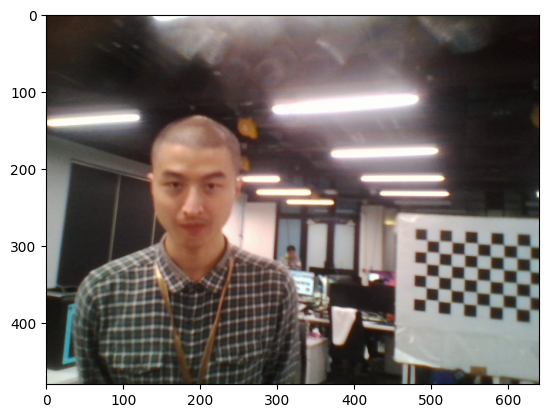

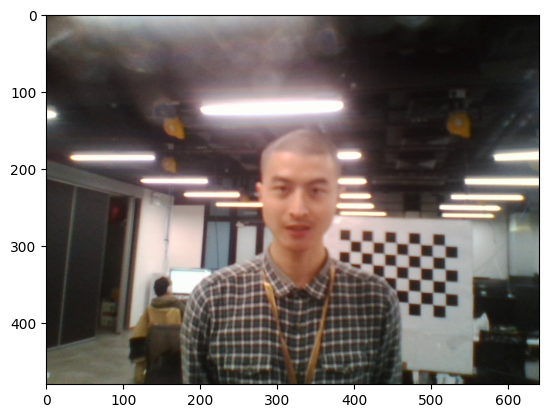

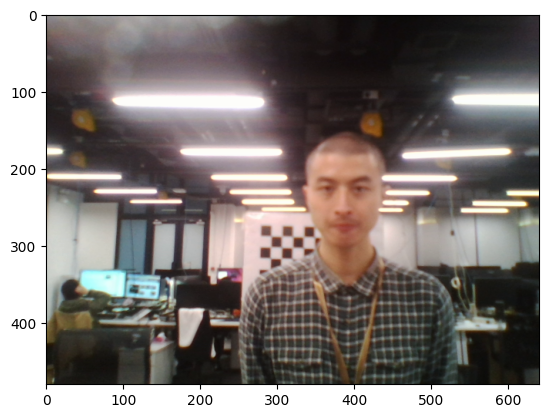

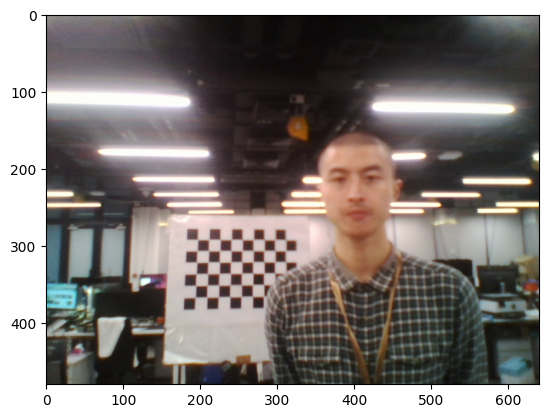

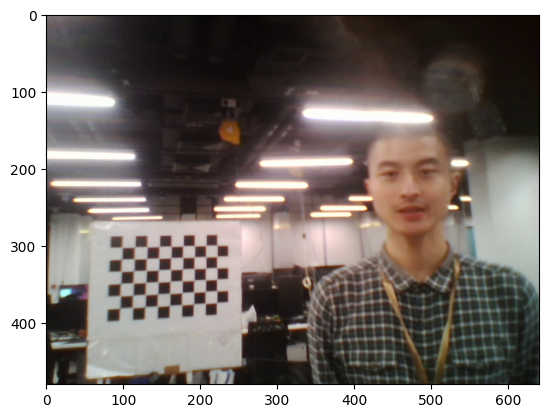

In [10]:
# Left Eye Image
left_img_list = [data['data'][i][eye+'_img'] for i in range(5)]
for i in range(5):
    plt.imshow(cv2.cvtColor(left_img_list[i], cv2.COLOR_BGR2RGB))
    plt.show()

In [11]:
gx = calib_params[eye]['x_center']
cx = camera_mtx_params[eye]['cx']
fx = camera_mtx_params[eye]['fx']

In [12]:
# Third Input
img_list = copy.deepcopy(left_img_list)
cam_mtx = copy.deepcopy(left_eye_camera_mtx)
dist_coef = copy.deepcopy(left_eye_dist_coef)

In [13]:
# Getting Target Pixels
pixel_list = []
disp_img_list = []
angle_list = []
for i in range(5):
    img = img_list[i]
    undist_img = cv2.undistort(img, cam_mtx, dist_coef)
    l_gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    detections = detector(l_gray, 0)
    if len(detections)>0:
        detection = detections[0]
        landmarks = predictor(img, detection)
        x_target = round((landmarks.part(40).x + landmarks.part(43).x)/2)
        y_target = round((landmarks.part(40).y + landmarks.part(43).y)/2)
        pixel_list.append((x_target, y_target))
        const_angle = math.degrees(math.atan2(gx-cx,fx))
        angle = math.degrees(math.atan2(x_target -cx,fx)) - const_angle
        angle_list.append(angle)
        
        disp_img = cv2.rectangle(undist_img, (detection.left(), detection.top()), (detection.right(), detection.bottom()), (0, 0, 255), 2)
        disp_img = cv2.drawMarker(disp_img, (x_target,y_target), color=(255, 0, 0), markerType=cv2.MARKER_TILTED_CROSS, markerSize=13, thickness=2)
        disp_img_list.append(disp_img)
    else:
        pixel_list.append((None, None))
        disp_img_list.append(img)
        angle_list.append(None)

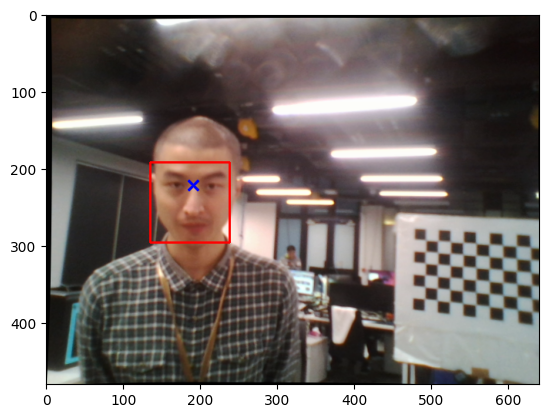

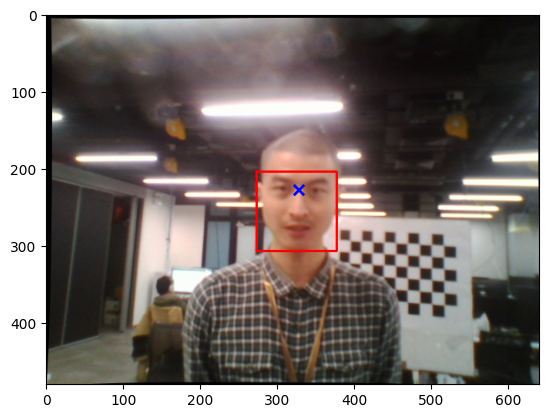

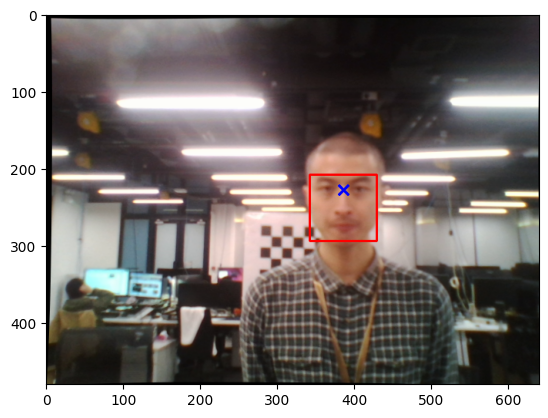

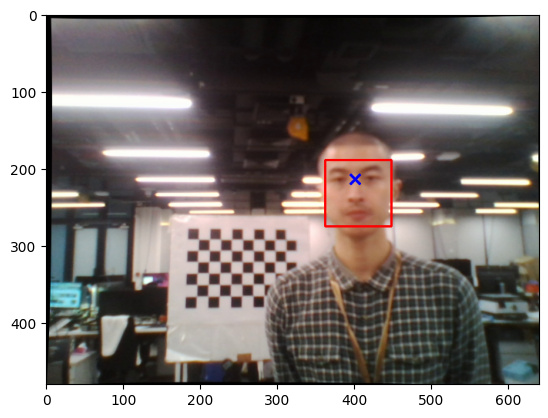

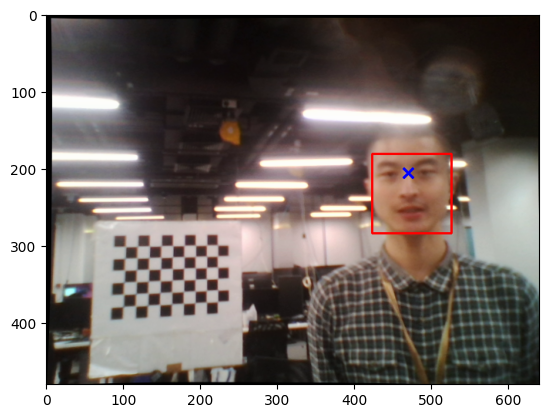

In [14]:
# Left Eye Image
for i in range(5):
    plt.imshow(cv2.cvtColor(disp_img_list[i], cv2.COLOR_BGR2RGB))
    plt.show()

Text(0, 0.5, 'Eye Deviation (deg)')

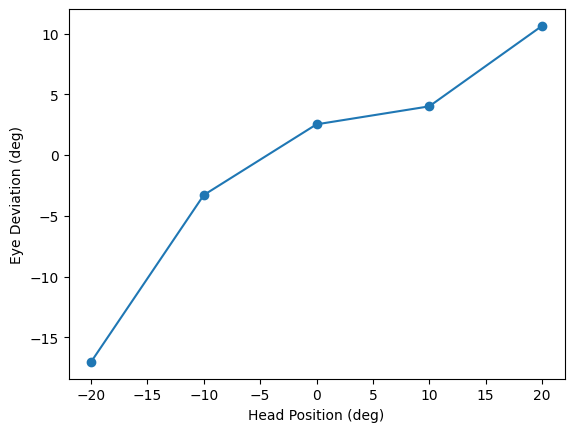

In [15]:
plt.plot([-20,-10,0,10,20],angle_list, marker='o')
plt.xlabel('Head Position (deg)')
plt.ylabel('Eye Deviation (deg)')

# Left Eye

## Automatic Processing Data

In [16]:
eye = 'left_eye'
gx = calib_params[eye]['x_center']
cx = camera_mtx_params[eye]['cx']
fx = camera_mtx_params[eye]['fx']
cam_mtx = copy.deepcopy(left_eye_camera_mtx)
dist_coef = copy.deepcopy(left_eye_dist_coef)
head_direction = [-20, -10, 0, 10, 20]

In [17]:
left_dict = {
    "subject_num": [],
    "head_rotation": [],
    "eye_deviation": [],
    "location": [],
}

In [18]:

for pickle_num in range(len(pickle_files)):
    for file_num in range(len(pickle_files[pickle_num])):
        data = read_pickle_file(pickle_files[pickle_num][file_num])
        img_list = [data['data'][i][eye+'_img'] for i in range(5)]
        
        pixel_list = []
        disp_img_list = []
        angle_list = []
        for i in range(5):
            img = img_list[i]
            undist_img = cv2.undistort(img, cam_mtx, dist_coef)
            l_gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
            detections = detector(l_gray, 0)
            if len(detections)>0:
                detection = detections[0]
                landmarks = predictor(img, detection)
                x_target = round((landmarks.part(40).x + landmarks.part(43).x)/2)
                y_target = round((landmarks.part(40).y + landmarks.part(43).y)/2)
                pixel_list.append((x_target, y_target))
                const_angle = math.degrees(math.atan2(gx-cx,fx))
                angle = math.degrees(math.atan2(x_target -cx,fx)) - const_angle
                angle_list.append(angle)
                
                disp_img = cv2.rectangle(undist_img, (detection.left(), detection.top()), (detection.right(), detection.bottom()), (0, 0, 255), 2)
                disp_img = cv2.drawMarker(disp_img, (x_target,y_target), color=(255, 0, 0), markerType=cv2.MARKER_TILTED_CROSS, markerSize=13, thickness=2)
                disp_img_list.append(disp_img)
            else:
                pixel_list.append((None, None))
                disp_img_list.append(img)
                angle_list.append(None)
            
            left_dict["subject_num"].append(pickle_num)
            left_dict["head_rotation"].append(head_direction[i])
            left_dict["eye_deviation"].append(angle_list[i])
            left_dict["location"].append(pickle_files[pickle_num][file_num])

left_pd = pd.DataFrame(left_dict)
left_pd.head()

subject_num  head_rotation  eye_deviation   
0            0            -20     -13.566961  \
1            0            -10      -7.737877   
2            0              0      -6.725532   
3            0             10       9.412434   
4            0             20      15.695298   

                                            location  
0  results/gaze_perception_subj2/perception_exp_s...  
1  results/gaze_perception_subj2/perception_exp_s...  
2  results/gaze_perception_subj2/perception_exp_s...  
3  results/gaze_perception_subj2/perception_exp_s...  
4  results/gaze_perception_subj2/perception_exp_s...

## Plotting

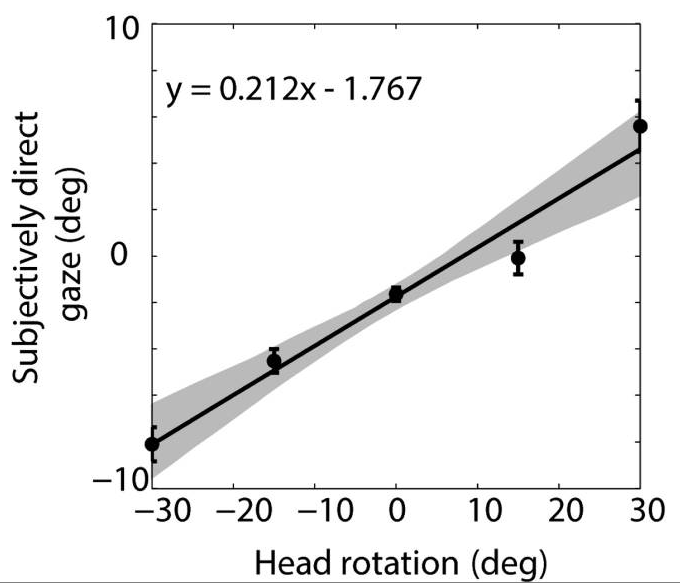

In [19]:
print(len(left_pd))
left_df = left_pd.dropna()
print(len(left_df))

240
230


Text(0, 0.5, 'Subjectively direct gaze (deg)')

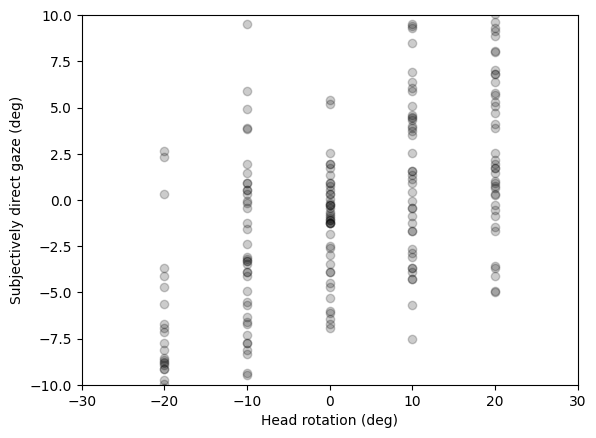

In [20]:
plt.figure()
plt.scatter(left_df["head_rotation"],left_df["eye_deviation"], alpha=0.2, color='black')
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')

In [21]:
# Mean and Standard Deviation Calculation
mean_list = []
std_list = []
for x in head_direction:
    temp_arr = left_df[left_df["head_rotation"]==x]['eye_deviation'].to_numpy()
    mean_val = np.nanmean(temp_arr)
    std_val = np.nanstd(temp_arr)
    mean_list.append(mean_val)
    std_list.append(std_val)

Text(0, 0.5, 'Subjectively direct gaze (deg)')

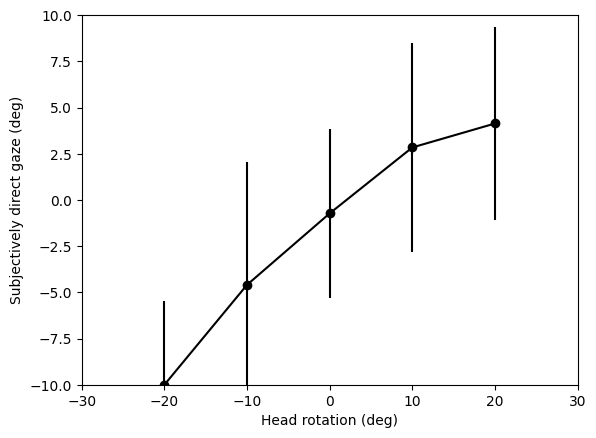

In [22]:
plt.errorbar(head_direction, mean_list, yerr=std_list, color='black', marker='o', markersize=6)
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')

## Linear Regression

In [23]:
# Slope Calculation

X = left_df['head_rotation'].values.reshape(-1,1)
y = left_df['eye_deviation'].values.reshape(-1,1)
reg = LinearRegression().fit(X, y)
score_val = reg.score(X, y).item()
coef_val = reg.coef_.squeeze().item()
intercept_val = reg.intercept_.item()
    
print('Coef Value:', coef_val)
print('Intercept Value:', intercept_val)

Coef Value: 0.3571106056663278
Intercept Value: -1.6732762971791741


In [24]:
x_lin = np.linspace(-30,30,100)
y_lin = coef_val*x_lin + intercept_val
y_compare = 0.091*x_lin -2.012

Text(0, 0.5, 'Subjectively direct gaze (deg)')

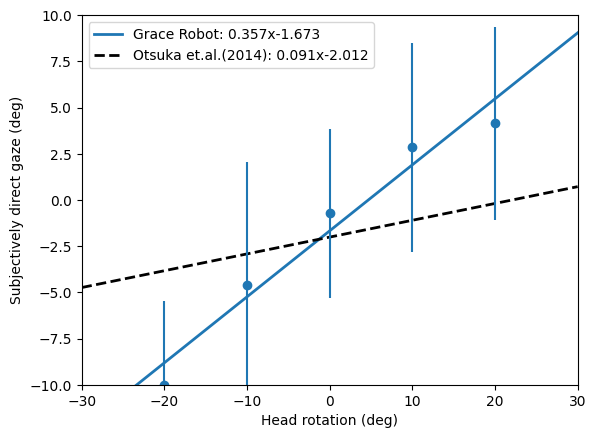

In [25]:
plt.plot(x_lin, y_lin, linewidth=2, color='#1f77b4')
plt.plot(x_lin, y_compare, linewidth=2, color='black', linestyle='--')
plt.errorbar(head_direction, mean_list, yerr=std_list, color='#1f77b4', marker='o', markersize=6, linestyle='')
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.legend(['Grace Robot: 0.357x-1.673', 'Otsuka et.al.(2014): 0.091x-2.012'])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')

# Right Eye

## Automatic Processing Data

In [26]:
eye = 'right_eye'
gx = calib_params[eye]['x_center']
cx = camera_mtx_params[eye]['cx']
fx = camera_mtx_params[eye]['fx']
cam_mtx = copy.deepcopy(right_eye_camera_mtx)
dist_coef = copy.deepcopy(right_eye_dist_coef)
head_direction = [-20, -10, 0, 10, 20]

In [27]:
right_dict = {
    "subject_num": [],
    "head_rotation": [],
    "eye_deviation": [],
    "location": [],
}

In [28]:

for pickle_num in range(len(pickle_files)):
    for file_num in range(len(pickle_files[pickle_num])):
        data = read_pickle_file(pickle_files[pickle_num][file_num])
        img_list = [data['data'][i][eye+'_img'] for i in range(5)]
        
        pixel_list = []
        disp_img_list = []
        angle_list = []
        for i in range(5):
            img = img_list[i]
            undist_img = cv2.undistort(img, cam_mtx, dist_coef)
            l_gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
            detections = detector(l_gray, 0)
            if len(detections)>0:
                detection = detections[0]
                landmarks = predictor(img, detection)
                x_target = round((landmarks.part(40).x + landmarks.part(43).x)/2)
                y_target = round((landmarks.part(40).y + landmarks.part(43).y)/2)
                pixel_list.append((x_target, y_target))
                const_angle = math.degrees(math.atan2(gx-cx,fx))
                angle = math.degrees(math.atan2(x_target -cx,fx)) - const_angle
                angle_list.append(angle)
                
                disp_img = cv2.rectangle(undist_img, (detection.left(), detection.top()), (detection.right(), detection.bottom()), (0, 0, 255), 2)
                disp_img = cv2.drawMarker(disp_img, (x_target,y_target), color=(255, 0, 0), markerType=cv2.MARKER_TILTED_CROSS, markerSize=13, thickness=2)
                disp_img_list.append(disp_img)
            else:
                pixel_list.append((None, None))
                disp_img_list.append(img)
                angle_list.append(None)
            
            right_dict["subject_num"].append(pickle_num)
            right_dict["head_rotation"].append(head_direction[i])
            right_dict["eye_deviation"].append(angle_list[i])
            right_dict["location"].append(pickle_files[pickle_num][file_num])

right_pd = pd.DataFrame(right_dict)
right_pd.head()

subject_num  head_rotation  eye_deviation   
0            0            -20     -13.664658  \
1            0            -10      -8.088983   
2            0              0      -6.969114   
3            0             10       9.963169   
4            0             20      16.135013   

                                            location  
0  results/gaze_perception_subj2/perception_exp_s...  
1  results/gaze_perception_subj2/perception_exp_s...  
2  results/gaze_perception_subj2/perception_exp_s...  
3  results/gaze_perception_subj2/perception_exp_s...  
4  results/gaze_perception_subj2/perception_exp_s...

## Plotting

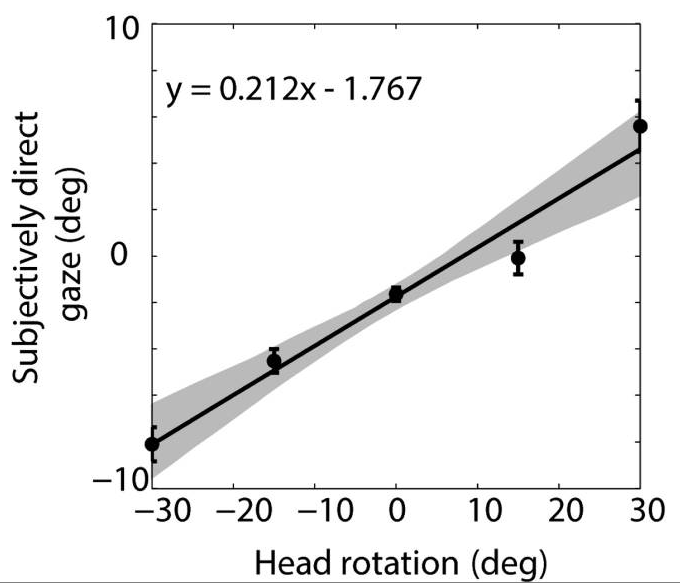

In [29]:
print(len(right_pd))
right_df = right_pd.dropna()
print(len(right_df))

240
229


Text(0, 0.5, 'Subjectively direct gaze (deg)')

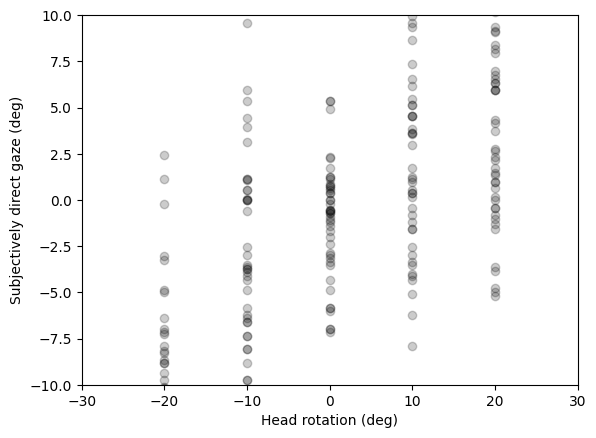

In [30]:
plt.figure()
plt.scatter(right_df["head_rotation"],right_df["eye_deviation"], alpha=0.2, color='black')
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')

In [31]:
# Mean and Standard Deviation Calculation
mean_list = []
std_list = []
for x in head_direction:
    temp_arr = right_df[right_df["head_rotation"]==x]['eye_deviation'].to_numpy()
    mean_val = np.nanmean(temp_arr)
    std_val = np.nanstd(temp_arr)
    mean_list.append(mean_val)
    std_list.append(std_val)

Text(0, 0.5, 'Subjectively direct gaze (deg)')

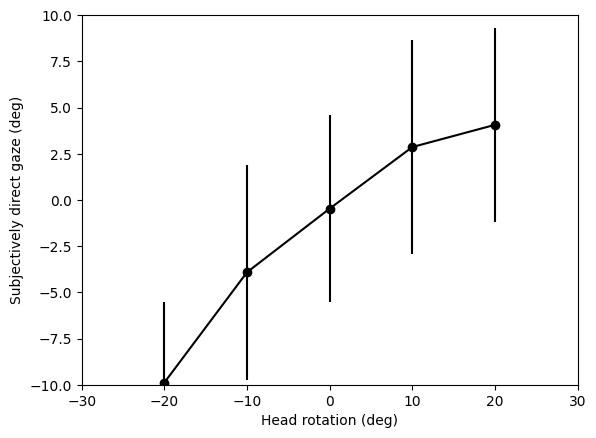

In [32]:
plt.errorbar(head_direction, mean_list, yerr=std_list, color='black', marker='o', markersize=6)
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')

## Linear Regression

In [33]:
# Slope Calculation

X = right_df['head_rotation'].values.reshape(-1,1)
y = right_df['eye_deviation'].values.reshape(-1,1)
reg = LinearRegression().fit(X, y)
score_val = reg.score(X, y).item()
coef_val = reg.coef_.squeeze().item()
intercept_val = reg.intercept_.item()
    
print('Coef Value:', coef_val)
print('Intercept Value:', intercept_val)

Coef Value: 0.3466110739297971
Intercept Value: -1.484807282326729


In [34]:
x_lin = np.linspace(-30,30,100)
y_lin = coef_val*x_lin + intercept_val
y_compare = 0.091*x_lin -2.012

Text(0, 0.5, 'Subjectively direct gaze (deg)')

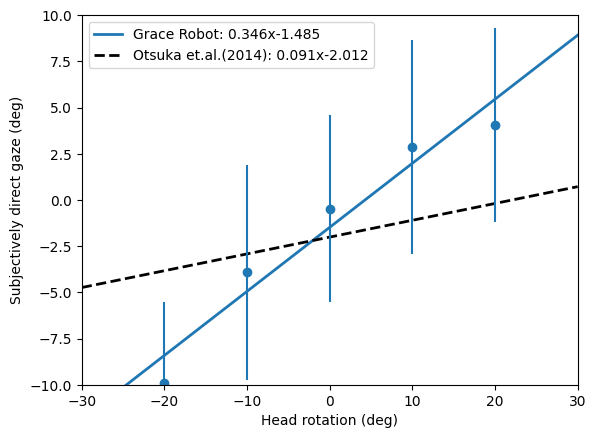

In [35]:
plt.plot(x_lin, y_lin, linewidth=2, color='#1f77b4')
plt.plot(x_lin, y_compare, linewidth=2, color='black', linestyle='--')
plt.errorbar(head_direction, mean_list, yerr=std_list, color='#1f77b4', marker='o', markersize=6, linestyle='')
plt.xlim([-30,30])
plt.ylim([-10,10])
plt.legend(['Grace Robot: 0.346x-1.485', 'Otsuka et.al.(2014): 0.091x-2.012'])
plt.xlabel('Head rotation (deg)')
plt.ylabel('Subjectively direct gaze (deg)')